In [59]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [60]:
# %matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt

import numpy as np

import random
import datetime
import time
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

import os
import shutil

Mounted at /content/gdrive


In [0]:
def Balacing(set,classes,id_classes,j): #j=indice delle classi visitate
  """
  This function has the purpose of balancing the dataset before using it in CNN.
    
  Starting from input data, we separate two distinct classes: one of the original classes
  extracted from the dataset that will act as a leaf (we call it 'class0'), and, excluding 
  the last step (consisting of only the two remaining classes) one "super" class containing 
  all the elements remaining (we call it 'class1')
    
  To keep the dataset balanced, we need the size of class0 to be equal to the size of class1. 
  In order to do that, we compute (based both on the size of class0 and the number of the 
  different classes in class1) the number of elements that have to be extracted from each
  subclass of class1 and we take them after reshuffling the elements to avoid taking
  always the same.
  """
  
  train=[]
  leaf=[]
  
  p=0
  train_dic={}
  class1_balanced=[]
  num_element_leaf=0
  
  classes_new=[]  
  
  for i in set: 
    
    if i[1] > j:
      train.append(i)     
      
    if i[1] == j: #salvo la foglia in dictionary
      leaf_label_int=i[1]
      leaf_label=str(i[1])
      leaf_data=i[0]
      
      leaf.append(leaf_data)
    
    
  print('leaf is ', leaf_label)   
  
  for i in train: #dictionary di train
    label=i[1]
    data=i[0]
    label=str(label)
    if label in train_dic:
      train_dic[label].append(data)
    else: 
      train_dic.update({label: []})
      train_dic[label].append(data)
  print(train_dic.keys())  
  elementsFromEachClass = int(round(len(leaf)/ len(train_dic.keys())))
  
  for k in train_dic.keys(): #bilancio il dictionary d train
    myClassElements = train_dic[k]
    random.shuffle(myClassElements)
    class1_balanced += myClassElements[:elementsFromEachClass]
  
  new_set_dic={}
  new_set_dic.update({'others': []})
  new_set_dic.update({leaf_label: []})
  
  
  
  classes_new.append('others')
  classes_new.append(leaf_label)
  
  id_classes_new={'others': 0, }
  id_classes_new.update({leaf_label: 1 })
  
  for i in class1_balanced:
        new_set_dic['others'].append(i)
  
  len_values=len(list(new_set_dic.values()))

  for i in leaf:#aggiungo il dictionary di leaf a quello che userò
        new_set_dic[leaf_label].append(i)
  

  #i valori della leaf sono in fondo
    
  new_set=[]
  count=0
  
  for i in list(new_set_dic.values()): #creo il nuovo vettore di vettore come nel formato che entra cambiando le labels
    
    if count == 0:
      for o in i:
        
        valore=(o,0) #data
        new_set.append(valore)
    else:
      for o in i:
        
        valore=(o,1) #data
        new_set.append(valore)
    count=count+1
  
  return new_set,classes_new,id_classes_new


def takeClass(trainset_gold):
  """
  This function is intended to remove a class from the previous ones.

  We need such a feature because using ImageFolder the dataset is loaded in its entirety, when our goal is 
  to look at changes in accuracy when adding a new class without completely retraining the network.
  """
  
  classExtraClasses = []
  classExtra = []
  classExtraIndex = {}

  img = trainset_gold.imgs
  
  length = len(img)
  dim = len(trainset_gold.classes)
  
  count=0
  for i in trainset_gold.imgs:
    if i[1] == dim-1:
      count=count+1
  
  for i in range(0,count):    
      element = img[length - i -1]
      img.remove(element)
      classExtra.append(element)     
    
  trainset_gold.samples=trainset_gold.imgs        
  classExtraClasses=trainset_gold.classes[dim-1]
  trainset_gold.classes.remove(classExtraClasses)  
    
  keys=list(trainset_gold.class_to_idx.keys())
  
  classExtraIndex=trainset_gold.class_to_idx.copy()
  
  for i in range(0,len(keys)-1):
    classExtraIndex.pop(keys[i])
  
  trainset_gold.class_to_idx.pop(keys[dim-1])
  
  return classExtraClasses,classExtra,classExtraIndex,trainset_gold

def addClass(trainset_old, newclass_imm, newclass_idx, newclass_classes):
  """
  The function mentioned above served to remove a class, this serves to add one.

  Also in this case, it is important to check the balance of our class data (done similarly to the Balancing function).
  """
  
  lenClass=len(newclass_imm)
  
  elementsFromEachClass = int(round(lenClass/ len(trainset_old.class_to_idx.keys())))
  
  #create imm in dict
  dic={}
  for i in trainset_old.imgs:
    if i[1] in dic.keys():
      dic[i[1]].append(i[0])
    else:
      dic.update({i[1] : []})
      dic[i[1]].append(i[0])
      
  class1_balanced = []
  #bilancio il dictionary 
  for k in dic.keys(): 
    myClassElements = dic[k]
    random.shuffle(myClassElements)
    class1_balanced += myClassElements[:elementsFromEachClass] 
  
  new_set_dic = {}
  new_set_dic.update({'others': []})
  new_set_dic.update({str(newclass_classes): []})
  
  for i in class1_balanced:
        new_set_dic['others'].append(i)
  
  len_values = len(list(new_set_dic.values()))

  for i in newclass_imm:       #aggiungo il dictionary di leaf a quello che userò
    new_set_dic[str(newclass_classes)].append(i[0]) 
  
  new_set=[]
  count=0
  
  for i in list(new_set_dic.values()): #creo il nuovo vettore di vettore come nel formato che entra cambiando le labels

    if count == 0:
      for o in i:
        
        valore = (o,0) #data
        new_set.append(valore)
    else:
      for o in i:
        
        valore = (o,1) #data
        new_set.append(valore)
    count = count + 1
  
 #classes
  classes = []
  classes.append('others')
  classes.append(str(newclass_classes))
  
 #index
  newdic = {}
  newdic.update({'others': 0})
  key = list(newclass_idx.keys())[0]
  newdic.update({key: 1})
  
  return new_set, classes, newdic
  

In [0]:
def test_accuracy(tree, dataloader, labels):
    ########TESTING PHASE###########
  
   #leaves=[6,9,4,1,2,7,8,3,5,0]
    #leaves=[0,1,2,3]
    leaves = labels
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            
            if labels == 4:
              continue
            
            images = images.cuda()   
            for i in range(0,4-1):#TotalClass-1):
                
                labels_renamed=labels #cosÃƒÂ¬ non perdo l'informazione
                if labels_renamed == leaves[i]:
                    labels_renamed = torch.tensor(1)

                else:
                    labels_renamed = torch.tensor(0)
                    

                labels_renamed = labels_renamed.cuda()  
                outputs =tree[i](images)  

                _, predicted = torch.max(outputs.data, 1)
                
                if predicted == 1:
                    class_predicted=leaves[i]
                    if class_predicted == labels:
                       correct=correct + 1
          
                    break
                else:
                  class_predicted=leaves[i+1]

            total += labels.size(0)
                #correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (accuracy))
    return accuracy

In [0]:
n_classes = 2           
#function to define the convolutional network
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

  def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        # we can insert a dropout here
        x = self.fc2(x)
        return x
      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
     #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

tree = [] #vector of nets
data_root = "gdrive/My Drive/bioinf_ds/"
test_root = "gdrive/My Drive/bioinf_ds_test/"

trainset = torchvision.datasets.ImageFolder(data_root, transform=transform_train, is_valid_file=None)
trainset_gold = torchvision.datasets.ImageFolder(data_root, transform=transform_train, is_valid_file=None)

classExtraClasses,classExtra,classExtraIndex,trainset_gold = takeClass(trainset_gold) #modifico gold

labelsArray = list(trainset_gold.class_to_idx.values())

testset = torchvision.datasets.ImageFolder(test_root, transform=transform_test, is_valid_file=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                            shuffle=True, num_workers=4,drop_last=True)

In [64]:
list(trainset_gold.class_to_idx.values())

[0, 1, 2, 3]

leaf is  0
dict_keys(['1', '2', '3'])
[1,    17] loss: 0.689
[2,    17] loss: 0.658
[3,    17] loss: 0.576
[4,    17] loss: 0.524
[5,    17] loss: 0.493
0  graph


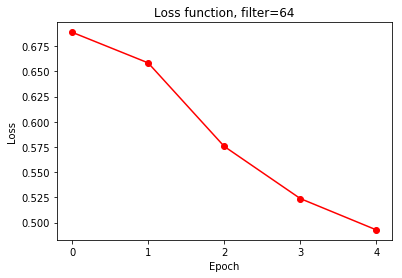

leaf is  1
dict_keys(['2', '3'])
[1,    10] loss: 0.691
[2,    10] loss: 0.678
[3,    10] loss: 0.648
[4,    10] loss: 0.596
[5,    10] loss: 0.542
1  graph


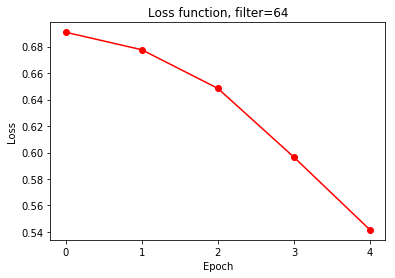

leaf is  2
dict_keys(['3'])
[1,    23] loss: 0.636
[2,    23] loss: 0.568
[3,    23] loss: 0.286
[4,    23] loss: 0.138
[5,    23] loss: 0.122
2  graph


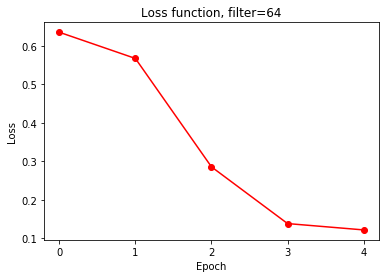

Accuracy of the network on the test set: 44 %


44.586776859504134

In [65]:
for j in range(0, 4-1):# totalClasses-1):
  
  trainset.imgs,trainset.classes,trainset.class_to_idx = Balacing(trainset_gold.imgs,trainset_gold.classes,trainset_gold.class_to_idx ,j) 
  
  trainset.samples = trainset.imgs
  
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                            shuffle=True, num_workers=4,drop_last=True)

  dataiter = iter(trainloader)

  net = CNN()

  net = net.cuda()

  criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
  optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

  ########TRAINING PHASE###########
  n_loss_print = len(trainloader) 
  
  loss_values = []
  n_epochs = 5
  
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs and cast them into cuda wrapper
           
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()
            
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % n_loss_print == (n_loss_print -1):    
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / n_loss_print))
        loss_values.append(running_loss / n_loss_print)
        running_loss = 0.0
          
  tree.append(net)
  epoch_values = np.arange(0, n_epochs, step = 1)
   
  print(j," graph")
  plt.title('Loss function, filter=64')
  plt.plot(loss_values, marker = 'o', color = 'red')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.xticks(epoch_values)

  plt.show()
  
test_accuracy(tree, testloader, labelsArray)

[1,    10] loss: 0.688
[2,    10] loss: 0.661
[3,    10] loss: 0.610
[4,    10] loss: 0.586
[5,    10] loss: 0.556
2  graph


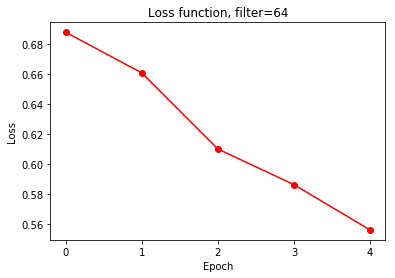

4
Accuracy of the network on the test set: 28 %


28.05785123966942

In [67]:
trainset.imgs,trainset.classes, trainset.class_to_idx = addClass(trainset_gold,classExtra,classExtraIndex,classExtraClasses)

trainset.samples = trainset.imgs

labelsArray.insert(0, classExtraIndex[classExtraClasses])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4,drop_last=True)
dataiter = iter(trainloader)

net = CNN()

net = net.cuda()
criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)
  ########TRAINING PHASE###########
n_loss_print = len(trainloader) 

loss_values = []
n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times
      net.train() #important for activating dropout and correctly train batchnorm
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper 
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
          print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / n_loss_print))
          loss_values.append(running_loss / n_loss_print)
          running_loss = 0.0
      
tree.insert(0,net)

epoch_values = np.arange(0, n_epochs, step = 1)
 
print(j," graph")
plt.title('Loss function, filter=64')
plt.plot(loss_values, marker = 'o', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_values)
plt.show()
print(len(tree))
test_accuracy(tree, testloader, labelsArray)
